# Исследование поведения пользователей сервиса Яндекс.Афиша

Во время стажировки в отдел аналитики Яндекс.Афиши нам назначили первое задание: помочь маркетологам оптимизировать маркетинговые затраты. 

В нашем распоряжении имеются следующие данные с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта
* выгрузка всех заказов за этот период
* статистика рекламных расходов

В процессе исследования требуется ответить на вопросы:
* как люди пользуются продуктом
* когда они начинают покупать
* сколько денег приносит каждый клиент
* когда клиент окупается

# Содержание
1. [Этап 1 - Загрузка и просмотр данных](#stage_1)
  * [Вывод первого этапа](#stage_1_summary)
        

2. [Этап 2 - Подготовка данных к анализу](#stage_2)
   
  * [Изменение наименований столбцов](#stage_2_names)
  * [Изменение типов данных](#stage_2_types)
  * [Поиск дублей](#stage_2_dubles)
  * [Поиск ошибок](#stage_2_err)
  * [Вывод второго этапа](#stage_2_summary)
       

3. [Этап 3 - Анализ данных](#stage_3)
   
  * [Посещаемость](#stage_3_visitors)
    * [Уникальные пользователи в разрезе платформ](#stage_3_visitors_unique_total)
    * [Количество уникальных сессий](#stage_3_visitors_unique)
    * [Количество сессий по месяцам](#stage_3_visitors_monthly)
    * [Длительность сессии](#stage_3_visitors_session_lenght)
    * [Retention rate](#stage_3_visitors_RT)
  * [Заказы](#stage_3_orders)
    * [Выручка](#stage_3_orders_revenue)
    * [Время до первого заказа](#stage_3_orders_first)
    * [Количество покупок на пользователя](#stage_3_orders_orders_num)
    * [Life Time Value](#stage_3_orders_LTV)
    * [Выручка по источникам привлечения](#stage_3_orders_per_source)
  * [Затраты на привлечение](#stage_3_costs)
    * [Стоимость привлечения пользователей в разрезе источников](#stage_3_costs_per_source)
    * [Затраты на привлечение пользователей по месяцам](#stage_3_costs_monthly)
    * [Стоимость привлечения одного пользователя](#stage_3_costs_per_user)
    * [Return On Investment](#stage_3_costs_ROI)
  * [Вывод третьего этапа](#stage_3_summary)


4. [Этап 4 - Рекомендации](#stage_4)


5. [Общий вывод](#conclusion)

Подключим необходимые библиотеки для работы с данными

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Этап 1 - Загрузка и просмотр данных<a id="stage_1"></a>

Загрузим наборы данных:

`visits` - лог сервера с данными о посещениях сайта

`orders` - выгрузка всех заказов за этот период

`costs` - статистика рекламных расходов

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Выведем на экран каждый датафрейм и просмотрим общую информацию о нем

### visits

In [3]:
visits

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица содержит следующую информацию:

* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

Необходимо перевести названия столбцов в строчные символы и заменить символы пробелом на нижние подчеркивания

Для столбцов `End Ts` и `Start Ts` тип данных нужно изменить с object на datetime

Необходимо будет проверить время сессий на ошибки (чтобы не было сессий которые закончились раньше чем начались)

### orders

In [5]:
orders

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Таблица содержит следующую информацию:

* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

Необходимо перевести названия столбцов в строчные символы и заменить символы пробелом на нижние подчеркивания

В столбце `Buy Ts` тип данных нужно изменить с object на datetime

In [7]:
costs

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Таблица содержит следующую информацию:

* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

В столбце `dt` тип данных нужно изменить с object на datetime

## Вывод<a id="stage_1_summary"></a>
Мы загрузили таблицы в отдельные датафреймы, провели беглый анализ содержащейся в них информации и типов данных и обнаружили следующее:

Пропущенных значений в таблицах нет

Во всех таблицах в столбцах, которые содержат информацию о датах и времени, необходимо изменить тип данных соответствующих столбцов с object на datetime

В таблицах `visits` и `orders` необходимо изменить наименования столбцов (привести к нижнему регистру и заменить символы пробелов на нижние подчеркивания)

Все таблицы необходимо будет проверить на дубли

В таблице `visits` необходимо проверить время сессий (чтобы не было сессий которые закончились раньше чем начались)

# Этап 2 - Подготовка данных к анализу<a id="stage_2"></a>

## Изменение наименований столбцов<a id="stage_2_names"></a>

В таблицах `visits` и `orders` наименования столбцов выглядят следующим образом

In [9]:
print(visits.columns)
print(orders.columns)

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')
Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')


Изменим регистр

In [10]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()

И заменим ' ' на '_'

In [11]:
visits.columns = visits.columns.str.replace(' ','_')
orders.columns = orders.columns.str.replace(' ','_')

После наших манипуляций наименования столбцов выглядят следующим образом

In [12]:
print(visits.columns)
print(orders.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')
Index(['buy_ts', 'revenue', 'uid'], dtype='object')


## Изменение типов данных<a id="stage_2_types"></a>

Данные о датах и времени содержатся в следующих столбцах:

`visits['end_ts']`

`visits['start_ts']`

`orders['buy_ts']`

`costs['dt']`

Изменим тип методом pandas.to_datetime

In [13]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

## Поиск дублей<a id="stage_2_dubles"></a>

Проверим каждую таблицу на дубли

In [14]:
visits.duplicated().sum()

0

In [15]:
orders.duplicated().sum()

0

In [16]:
costs.duplicated().sum()

0

Дублей в таблицах нет

## Поиск ошибок<a id="stage_2_err"></a>

Изменим порядок столбцов в таблице `visits`

In [17]:
visits = visits[['device', 'source_id', 'start_ts', 'end_ts', 'uid']]

Проверим на наличие записей о сессиях в которых время начала сессии позже ее начала

In [18]:
visits.query('start_ts > end_ts')

,device,source_id,start_ts,end_ts,uid
4181,desktop,3,2018-03-25 03:50:00,2018-03-25 03:18:00,13092152539246794986
177972,desktop,9,2018-03-25 03:55:00,2018-03-25 03:09:00,4621202742905035453


Мы нашли всего две таких записи, посчитаем процент от общего количества

In [19]:
len(visits.query('start_ts > end_ts')) / len(visits) * 100

0.0005564830272676682

Всего 0.0006%, удалим их из таблицы

In [20]:
visits = visits.drop(visits.query('end_ts < start_ts').index).reset_index(drop=True)

## Вывод<a id="stage_2_summary"></a>

На этапе предобработки данных мы изменили наименования столбцов в таблицах `visits` и `orders` (привели их к нижнему регистру и заменили пробелы на нижние подчеркивания)

Изменили тип данных в столбцах содержащих даты

Проверили все таблицы на дубликаты (они не были обнаружены)

Удалили из таблицы `visits` 2 записи о сессиях в которых время начала сессии позже ее начала

# Этап 3 - Анализ данных<a id="stage_3"></a>

## Посещаемость<a id="stage_3_visitors"></a>

Для того чтобы определить количество посетителей Яндекс.Афиши в день, неделю и месяц нам необходимо ввести в таблицу дополнительные столбцы `day`, `week` и `month` в них мы сохраним день, неделю и месяц начала сессии

In [21]:
visits['day'] = visits['start_ts'].astype('datetime64[D]')
visits['week'] = visits['start_ts'].astype('datetime64[D]') - pd.to_timedelta(visits['start_ts'].dt.dayofweek, unit='D')
visits['month'] = visits['start_ts'].astype('datetime64[M]')

### Уникальные пользователи в разрезе платформ<a id="stage_3_visitors_unique_total"></a>

In [22]:
users_total = visits.pivot_table(index='device', values='uid', aggfunc=['count',lambda x: len(x.unique())])
users_total.columns = ['total','unique']
users_total['ratio, %'] = (users_total['unique'] / users_total['total'] * 100).round(2)
users_total

,total,unique,"ratio, %"
device,,,
desktop,262565,164523,62.66
touch,96833,71345,73.68


Доля уникальных пользователей на мобильных платформах на 9% выше чем на персональном компьютере

Расчитаем количество уникальных пользователей в день, в неделю и в месяц

In [23]:
users_daily = visits.pivot_table(index=['device','day'], values='uid', aggfunc=lambda x: len(x.unique())).\
              reset_index()[['device','uid']].pivot_table(index='device', values='uid', aggfunc='mean').round(2)

users_weekly = visits.pivot_table(index=['device','week'], values='uid', aggfunc=lambda x: len(x.unique())).\
               reset_index()[['device','uid']].pivot_table(index='device', values='uid', aggfunc='mean').round(2)

users_monthly = visits.pivot_table(index=['device','month'], values='uid', aggfunc=lambda x: len(x.unique())).\
                reset_index()[['device','uid']].pivot_table(index='device', values='uid', aggfunc='mean').round(2)

nunique_users = pd.concat([users_daily,users_weekly,users_monthly], axis=1).reset_index()
nunique_users.columns = ['device','daily','weekly','monthly']
nunique_users.loc[2] = nunique_users.sum()
nunique_users.loc[2,'device'] = 'total'
nunique_users

,device,daily,weekly,monthly
0,desktop,659.24,4129.51,16724.92
1,touch,252.87,1634.92,6825.92
2,total,912.11,5764.43,23550.84


Text(0, 0.5, 'Количество сессий')

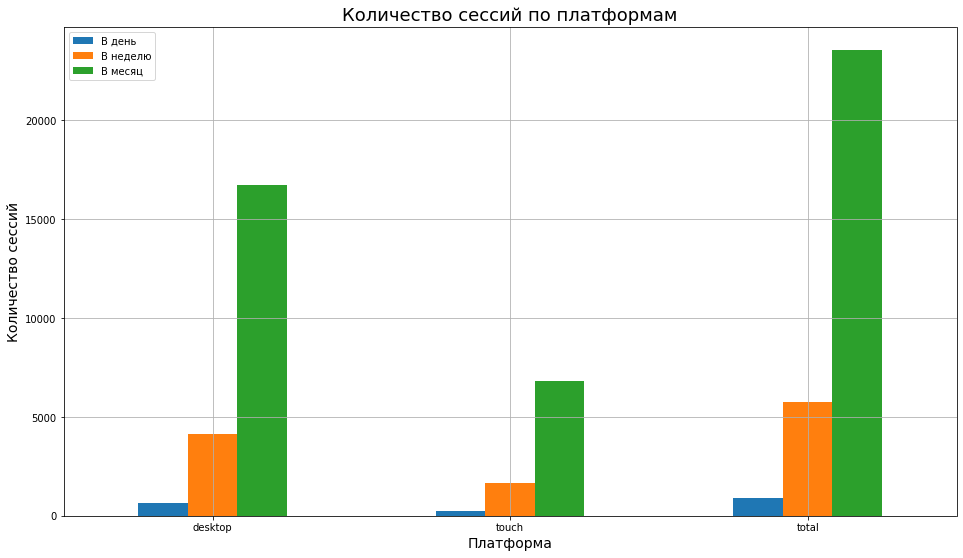

In [24]:
nunique_users.plot(kind='bar', y=['daily','weekly','monthly'], x='device', figsize=(16,9), grid=True, rot=0)
plt.legend(['В день','В неделю','В месяц'])
plt.title('Количество сессий по платформам', fontsize=18)
plt.xlabel('Платформа', fontsize=14)
plt.ylabel('Количество сессий', fontsize=14)

На платформе `desktop` (настольные компьютеры) у Яндекс.Афиши на 40% больше пользователей чем на платформе `touch` (мобильные платформы)

В среднем, в течении года, было 912 уникальных посетителей в день, 5764 в неделю и 23550 в месяц

### Количество сессий по месяцам<a id="stage_3_visitors_monthly"></a>

Построим график изменения общей посещаемости за год

Text(0, 0.5, 'Количество сессий')

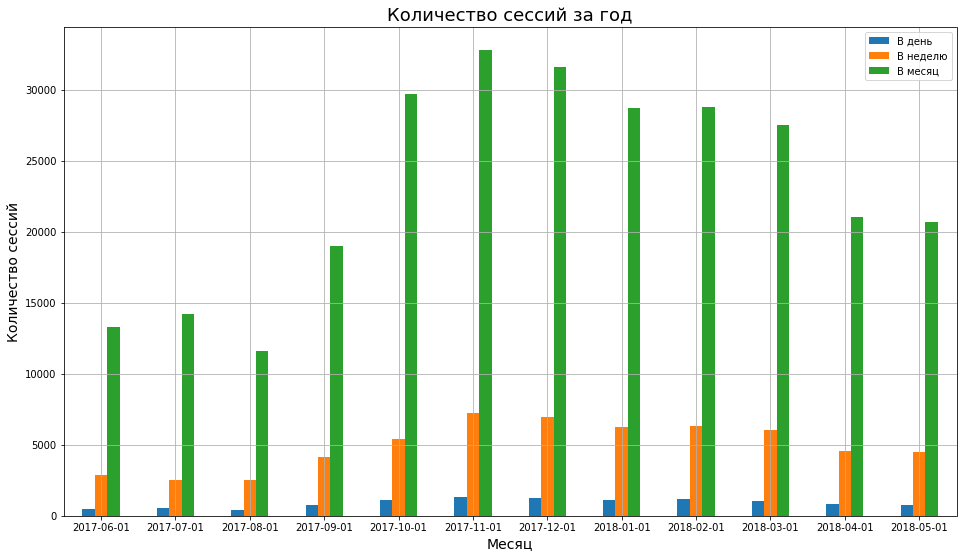

In [25]:
users_daily_year = visits.pivot_table(index=['month','day'], values='uid', 
                                 aggfunc=lambda x: len(x.unique())).\
              reset_index()[['month','uid']].pivot_table(index='month', values='uid', 
                                                         aggfunc='mean').round(2).reset_index()

users_weekly_year = visits.pivot_table(index=['month','week'], values='uid', 
                                 aggfunc=lambda x: len(x.unique())).\
              reset_index()[['month','uid']].pivot_table(index='month', values='uid', 
                                                         aggfunc='mean').round(2).reset_index()

users_monthly_year = visits.pivot_table(index=['month'], values='uid', 
                                 aggfunc=lambda x: len(x.unique())).\
              reset_index()[['month','uid']].pivot_table(index='month', values='uid', 
                                                         aggfunc='mean').round(2).reset_index()

users_daily_year.columns = ['month','daily']
users_weekly_year.columns = ['month','weekly']
users_monthly_year.columns = ['month','monthly']

pivot_users_year = users_daily_year.merge(users_weekly_year, on='month', how='left')
pivot_users_year = pivot_users_year.merge(users_monthly_year, on='month', how='left')
pivot_users_year['month'] = pivot_users_year['month'].dt.date

pivot_users_year.plot(kind='bar', x='month', y=['daily','weekly','monthly'], figsize=(16,9), 
                      grid=True, rot=0)
plt.legend(['В день','В неделю','В месяц'])
plt.title('Количество сессий за год', fontsize=18)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Количество сессий', fontsize=14)

На диаграмме отчетливо видно что в конце года количество посещений значительно увеличивается, это может свидетельствовать о сезонности спроса

Рассчитаем количество уникальных сессий по месяцам

In [26]:
pivot = visits.pivot_table(index='month', values='uid', aggfunc=['count',lambda x: len(x.unique())]).reset_index()
pivot['month'] = pivot['month'].dt.date
pivot.columns = ['month','count','nunique']
pivot['ratio'] = (pivot['count'] /pivot['nunique']).round(2)
pivot

,month,count,nunique,ratio
0,2017-06-01,16505,13259,1.24
1,2017-07-01,17828,14183,1.26
2,2017-08-01,14355,11631,1.23
3,2017-09-01,23907,18975,1.26
4,2017-10-01,37903,29692,1.28
5,2017-11-01,43969,32797,1.34
6,2017-12-01,41983,31557,1.33
7,2018-01-01,36939,28716,1.29
8,2018-02-01,37182,28749,1.29
9,2018-03-01,35677,27473,1.30


В конце года наблюдается некоторое увеличение количества сессий на одного пользователя, но оно не достаточно для того чтобы компенсировать значительный роcт общего количества посещений, это значит что в конце года мы получаем больше уникальных посетителей, еще одно подтверждение сезонности спроса

### Количество уникальных сессий<a id="stage_3_visitors_unique"></a>

В день

In [27]:
sessions = visits.pivot_table(index='day', values='uid', aggfunc=['count',lambda x: len(x.unique())])
sessions.columns = ['Всего','Уникальных']
sessions['ratio'] = sessions['Всего'] / sessions['Уникальных']
sessions.mean()

Всего         987.357143
Уникальных    907.991758
ratio           1.082166
dtype: float64

В неделю

In [28]:
sessions = visits.pivot_table(index='week', values='uid', aggfunc=['count',lambda x: len(x.unique())])
sessions.columns = ['Всего','Уникальных']
sessions['ratio'] = sessions['Всего'] / sessions['Уникальных']
sessions.mean()

Всего         6781.094340
Уникальных    5716.245283
ratio            1.179020
dtype: float64

В месяц

In [29]:
sessions = visits.pivot_table(index='month', values='uid', aggfunc=['count',lambda x: len(x.unique())])
sessions.columns = ['Всего','Уникальных']
sessions['ratio'] = sessions['Всего'] / sessions['Уникальных']
sessions.mean()

Всего         29949.833333
Уникальных    23228.416667
ratio             1.280883
dtype: float64

Судя по соотношению в среднем на одного пользователя приходится одна сессия в день, но в разрезе по неделям и месяцам находится больше пользователей которые заходят на платформу несколько раз за период, метрика по месяцам и составляет 1.3 посещения за период

### Длительность сессии<a id="stage_3_visitors_session_lenght"></a>

Запишем в столбец `session_lenght` длительность сесcии в секундах

In [30]:
visits['session_lenght'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Выведем основные статистические покаатели этого столбца на экран (в разрезе платформ)

In [31]:
pd.concat([visits['session_lenght'].describe().round(),
           visits.query('device == "desktop"')['session_lenght'].describe().round(),
           visits.query('device == "touch"')['session_lenght'].describe().round()],
          axis=1, 
          keys=['all','desktop','touch'])

,all,desktop,touch
count,359398.0,262565.0,96833.0
mean,643.0,703.0,480.0
std,997.0,1067.0,753.0
min,0.0,0.0,0.0
25%,120.0,120.0,60.0
50%,300.0,360.0,180.0
75%,840.0,900.0,600.0
max,42660.0,42660.0,30840.0


Средняя длительность сессии 643 секунды, медианная 300 секунд, по платформам значения различаются:

* настольные компьютеры<br>
  cредняя длительность сессии 703 секунды, медианная 360 секунд
* мобильные платформы<br>
  cредняя длительность сессии 480 секунд, медианная 180 секунд
  
Такая большая разница между средними и медианными значениями вызвана большим количеством выбросов

Для того чтобы определить диапазон для построения гистограмм поделим весь диапазон на корзины

In [32]:
pd.cut(visits['session_lenght'], bins=25).reset_index().groupby('session_lenght').count().query('index > 0')

,index
session_lenght,
"(-42.66, 1706.4]",327390
"(1706.4, 3412.8]",24583
"(3412.8, 5119.2]",4951
"(5119.2, 6825.6]",1381
"(6825.6, 8532.0]",541
"(8532.0, 10238.4]",238
"(10238.4, 11944.8]",131
"(11944.8, 13651.2]",63
"(13651.2, 15357.6]",40


Основная масса значений расположена в диапазоне до 10000 секунд, в нем мы и будем строить гистограммы

Text(0, 0.5, 'Частота')

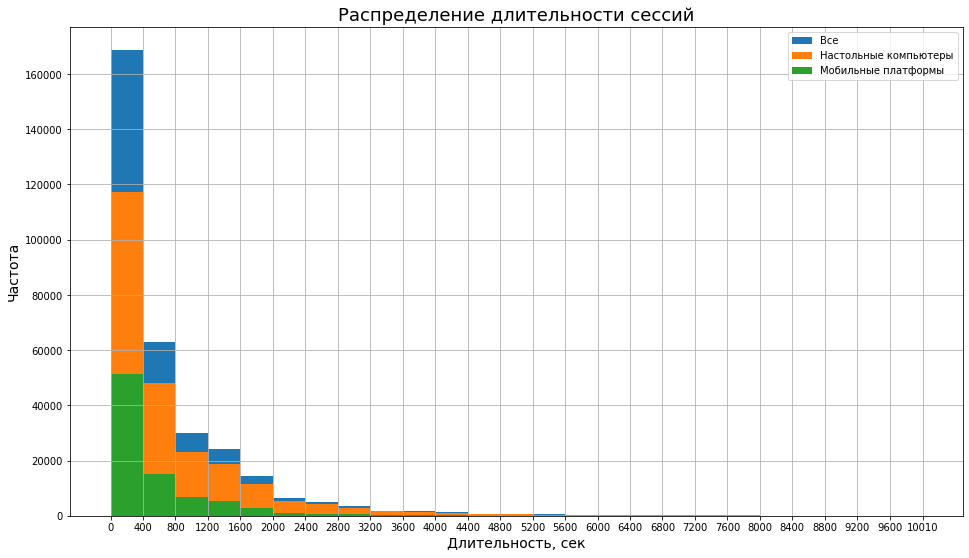

In [33]:
hist_range = (0,10000)
hist_bins = 25
ticks = pd.cut(hist_range, bins=hist_bins, labels=False, retbins=True, right=False)[1]

visits.query('session_lenght > 0')['session_lenght'].plot(kind='hist', figsize=(16,9), 
                                                          bins=hist_bins, range=hist_range, grid=True)
visits.query('session_lenght > 0 & device == "desktop"')['session_lenght'].plot(kind='hist', figsize=(16,9), 
                                                                                bins=hist_bins, range=hist_range, grid=True)
visits.query('session_lenght > 0 & device == "touch"')['session_lenght'].plot(kind='hist', figsize=(16,9), 
                                                                                bins=hist_bins, range=hist_range, grid=True)
plt.xticks(ticks)
plt.legend(['Все','Настольные компьютеры','Мобильные платформы'])
plt.title('Распределение длительности сессий', fontsize=18)
plt.xlabel('Длительность, сек', fontsize=14)
plt.ylabel('Частота', fontsize=14)

На графике отчетливо видно что большинство сессий завершается в течении 10 минут

### Retention rate<a id="stage_3_visitors_RT"></a>

Для расчета коэффициента удержания нам понадобится разделить всех пользователей на когорты, в данном случае объединяющим фактором будет месяц первого входа в систему, рассчитаем его

In [34]:
first_activity = visits.pivot_table(index='uid', values='start_ts', aggfunc='min').reset_index()
first_activity.columns = ['uid', 'first_activity']
first_activity.head()

,uid,first_activity
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


Добавим этот столбец в основную таблицу и выделим из него месяц

In [35]:
visits = visits.merge(first_activity, on='uid', how='left')
visits['first_activity_month'] = visits['first_activity'].astype('datetime64[M]')

Рассчитаем на каком месяце активности пользователя была начата сессия

In [36]:
visits['lifetime'] = (visits['start_ts'] - visits['first_activity']) / np.timedelta64(1,'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

Поделим все сессии на когорты

In [37]:
cohorts_sessions = visits.pivot_table(index=['device','first_activity_month','lifetime'], values='uid', 
                                      aggfunc=lambda x: len(x.unique())).reset_index()
cohorts_sessions.columns = ['device','first_activity_month','lifetime','un_users_cnt']
cohorts_sessions.head()

,device,first_activity_month,lifetime,un_users_cnt
0,desktop,2017-06-01,0,9762
1,desktop,2017-06-01,1,791
2,desktop,2017-06-01,2,589
3,desktop,2017-06-01,3,672
4,desktop,2017-06-01,4,750


Среди когорт выделим первый период (нулевой период активности)

In [38]:
first_months_users = cohorts_sessions[cohorts_sessions['lifetime'] == 0][['device','first_activity_month','un_users_cnt']]
first_months_users.columns = ['device','first_activity_month','un_users_cnt_0_lft']
first_months_users.head()

,device,first_activity_month,un_users_cnt_0_lft
0,desktop,2017-06-01,9762
13,desktop,2017-07-01,9312
25,desktop,2017-08-01,7456
36,desktop,2017-09-01,11739
46,desktop,2017-10-01,18454


Добавим выделенные значения к основной таблице с когортами

In [39]:
cohorts_sessions = cohorts_sessions.merge(first_months_users, on=['device','first_activity_month'], how='left')
cohorts_sessions.head()

,device,first_activity_month,lifetime,un_users_cnt,un_users_cnt_0_lft
0,desktop,2017-06-01,0,9762,9762
1,desktop,2017-06-01,1,791,9762
2,desktop,2017-06-01,2,589,9762
3,desktop,2017-06-01,3,672,9762
4,desktop,2017-06-01,4,750,9762


Рассчитаем коэффициент удержания для каждой когорты за каждый месяц жизни

In [40]:
cohorts_sessions['retention'] = cohorts_sessions['un_users_cnt'] / cohorts_sessions['un_users_cnt_0_lft']
cohorts_sessions.head()

,device,first_activity_month,lifetime,un_users_cnt,un_users_cnt_0_lft,retention
0,desktop,2017-06-01,0,9762,9762,1.000000
1,desktop,2017-06-01,1,791,9762,0.081028
2,desktop,2017-06-01,2,589,9762,0.060336
3,desktop,2017-06-01,3,672,9762,0.068838
4,desktop,2017-06-01,4,750,9762,0.076829


Построим сводные таблицы:

* `retention_pivot_desktop` - сессии на настольных компьютерах
* `retention_pivot_touch` - сессии на мобильных устройствах

In [41]:
retention_pivot_desktop = cohorts_sessions.query('device == "desktop"').pivot_table(index='first_activity_month', 
                                                                                    columns='lifetime', values='retention')
retention_pivot_touch = cohorts_sessions.query('device == "touch"').pivot_table(index='first_activity_month', 
                                                                                columns='lifetime', values='retention')

И отобразим карты теплоты

Text(123.0, 0.5, 'Когорта')

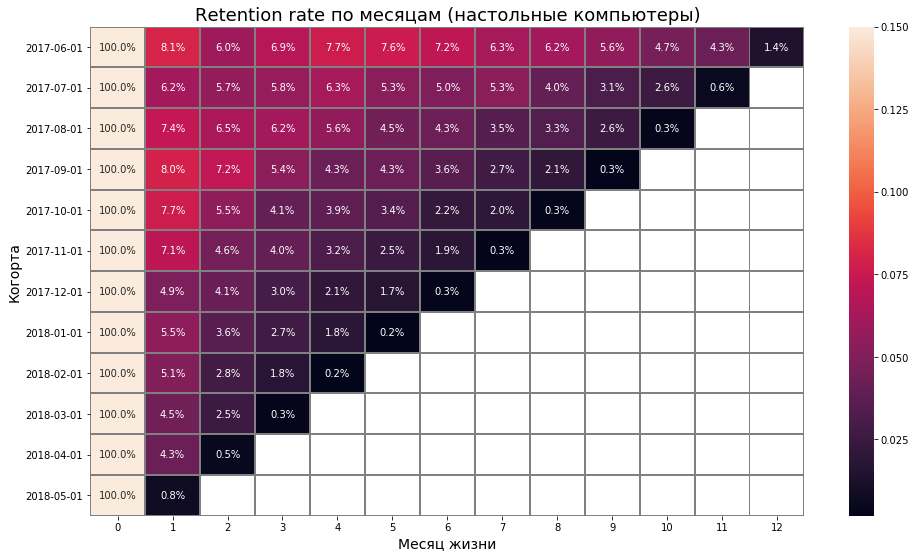

In [42]:
plt.figure(figsize=(16,9))
sns.heatmap(retention_pivot_desktop, annot=True, linewidths=1, fmt='.1%', linecolor='gray', 
            yticklabels=retention_pivot_desktop.index.date, vmax=0.15)
plt.title('Retention rate по месяцам (настольные компьютеры)', fontsize=18)
plt.xlabel('Месяц жизни', fontsize=14)
plt.ylabel('Когорта', fontsize=14)

Text(123.0, 0.5, 'Когорта')

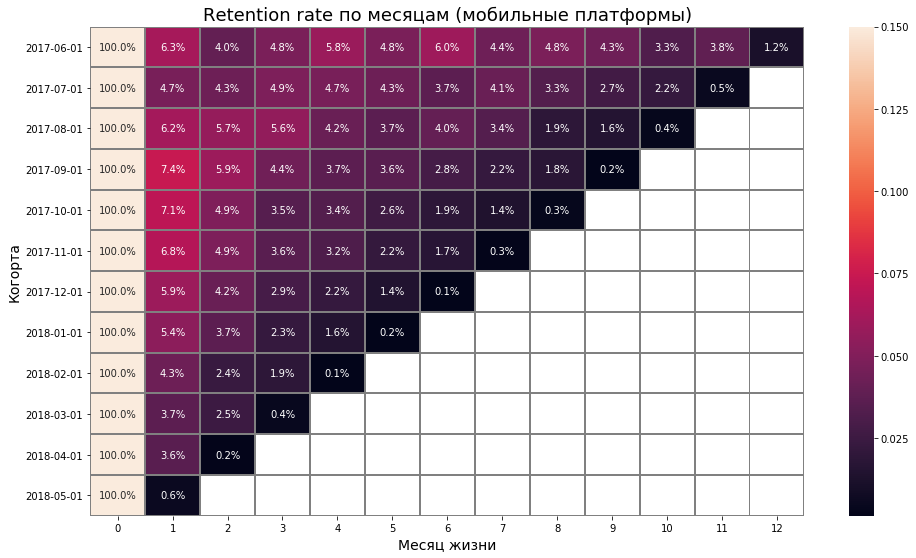

In [43]:
plt.figure(figsize=(16,9))
sns.heatmap(retention_pivot_touch, annot=True, linewidths=1, fmt='.1%', linecolor='gray', 
            yticklabels=retention_pivot_touch.index.date, vmax=0.15)
plt.title('Retention rate по месяцам (мобильные платформы)', fontsize=18)
plt.xlabel('Месяц жизни', fontsize=14)
plt.ylabel('Когорта', fontsize=14)

В течении года коэффициент удержания снижается, но наблюдается его увеличение во время новогодних праздников (декабрь-январь). В среднем коэффициент удержания среди пользователей которые используют настольные компьютеры выше чем на мобильных платформах

## Заказы<a id="stage_3_orders"></a>

В таблице `orders` размещается информация о заказах совершенных на платформе: дата, выручка и идентификатор пользователя

### Выручка<a id="stage_3_orders_revenue"></a>

За каждый заказ, совершенный с платформы, Яндекс.Афиша получает определенный процент от суммы заказа, всего, за год, выручка составила

In [44]:
orders['revenue'].sum().round(2)

252057.2

Выведем основные статистические показатели столбца `revenue`

In [45]:
orders['revenue'].describe().round(2)

count    50415.00
mean         5.00
std         21.82
min          0.00
25%          1.22
50%          2.50
75%          4.89
max       2633.28
Name: revenue, dtype: float64

Всего в таблице 50415 покупок, **средний чек составляет 5.00** а **медианный 2.50**, распределение по перцентилям показывает что 75% покупок укладываются в средний чек, построим распределение на гистограмме

Определим диапазоны в которых расположены наблюдения

In [46]:
pd.cut(orders['revenue'], bins=25).reset_index().groupby('revenue').count().query('index > 0')

,index
revenue,
"(-2.633, 105.331]",50306
"(105.331, 210.662]",74
"(210.662, 315.994]",11
"(315.994, 421.325]",9
"(421.325, 526.656]",2
"(526.656, 631.987]",3
"(631.987, 737.318]",1
"(842.65, 947.981]",1
"(947.981, 1053.312]",1


Большая часть покупок (99.78%) помещается в первой корзине - от 0 до 106, этот диапазон мы и будем использовать для вывода распределения

Text(0, 0.5, 'Частота')

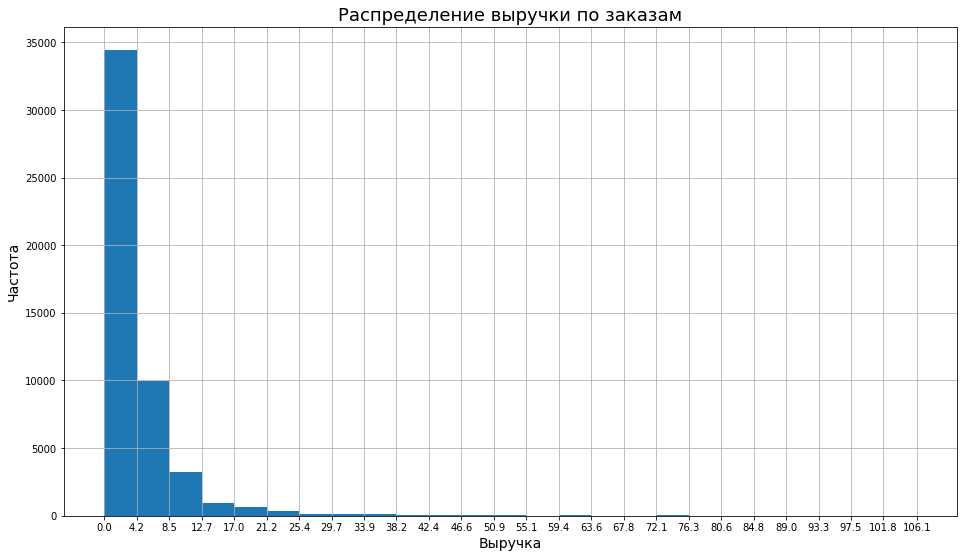

In [47]:
hist_bins = 25
hist_range = (0,106)
ticks = pd.cut(hist_range, bins=hist_bins, labels=False, retbins=True, right=False)[1]

orders['revenue'].plot(kind='hist', bins=25, range=hist_range, grid=True, figsize=(16,9))
plt.xticks(ticks)
plt.title('Распределение выручки по заказам', fontsize=18)
plt.xlabel('Выручка', fontsize=14)
plt.ylabel('Частота', fontsize=14)

Построим суммарное распределение выручки по месяцам, для этого добавим в таблицу столбец с месяцем покупки

In [48]:
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')

Text(0, 0.5, 'Выручка')

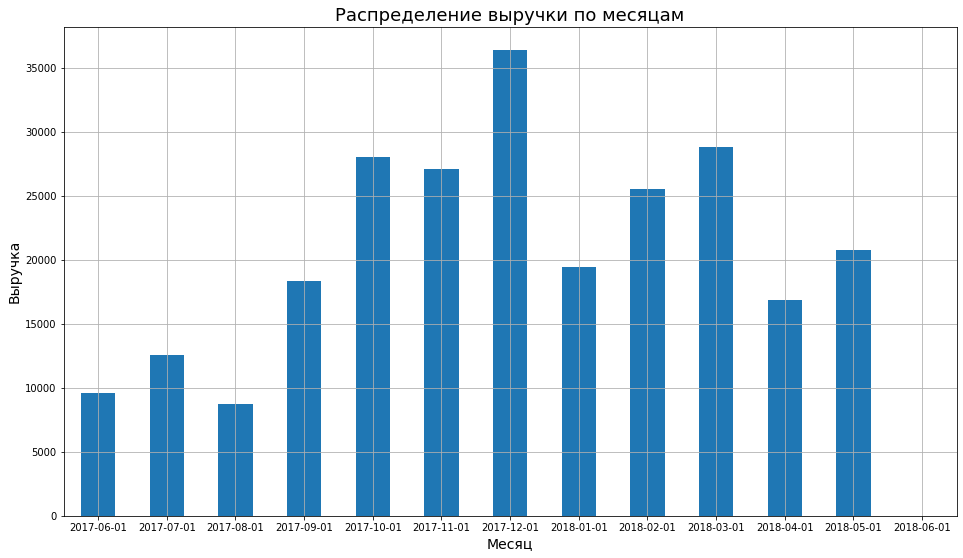

In [49]:
orders_per_month = orders.pivot_table(index='buy_month', values='revenue', aggfunc='sum').reset_index()
orders_per_month['buy_month'] = orders_per_month['buy_month'].dt.date
orders_per_month.plot(kind='bar', x='buy_month', y='revenue', figsize=(16,9), legend=False, grid=True, rot=0)
plt.title('Распределение выручки по месяцам', fontsize=18)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Выручка', fontsize=14)

В конце года, выручка значительно возрастает

Согласно описанию данных, в нашем распоряжении должна быть информация только по май 2018 года, на графике мы видим сведения за июнь 2018, выведем их на экран

In [50]:
orders.query('buy_month == "2018-06-01"')

,buy_ts,revenue,uid,buy_month
50414,2018-06-01 00:02:00,3.42,83872787173869366,2018-06-01


Один заказ от пользователя который совершил покупку в 00:02:00 2018-06-01, для того чтобы эта запись не исказила наш когортный анализ - удалим ее из таблицы

In [51]:
orders = orders.drop(orders.query('buy_month == "2018-06-01"').index).reset_index(drop=True)

Средняя выручка в месяц составляет

In [52]:
orders_per_month['revenue'].mean().round(2)

19389.02

In [53]:
revenue_per_month = orders.pivot_table(index='buy_month', values=['revenue','uid'], 
                                       aggfunc={'revenue':'mean','uid':'count'}).reset_index()
revenue_per_month

,buy_month,revenue,uid
0,2017-06-01,4.060106,2354
1,2017-07-01,5.306589,2363
2,2017-08-01,4.847139,1807
3,2017-09-01,5.416448,3387
4,2017-10-01,4.928280,5679
5,2017-11-01,4.783518,5659
6,2017-12-01,5.852139,6218
7,2018-01-01,4.112927,4721
8,2018-02-01,4.840095,5281
9,2018-03-01,5.413930,5326


В течении года средний чек держится на одном уровне, но начиная с октября начинается рост ежемесячного количества покупок, он достигает своего пика в декабре (три месяца роста) и снижается только к середине весны (в апреле), на данный момент сомнений в сезонности спроса нет - с конца весны до середины осени спрос на Афише находится на своем минимуме

### Время до первого заказа<a id="stage_3_orders_first"></a>

Рассчитаем дату первой покупки каждого пользователя

In [54]:
first_buy = orders.pivot_table(index='uid', values='buy_ts', aggfunc='min').reset_index()
first_buy.columns = ['uid', 'first_buy']

Присоединим ее к основной таблице

In [55]:
orders = orders.merge(first_buy, on='uid', how='left')
orders.head()

,buy_ts,revenue,uid,buy_month,first_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00


Добавим ранее рассчитанную дату первой активности пользователя

In [56]:
orders = orders.merge(first_activity, on='uid', how='left')
orders.head()

,buy_ts,revenue,uid,buy_month,first_buy,first_activity
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01 07:31:00


Найдем разницу между датой первой покупки и датой первой активности пользователя на платформе и выведем на экран основные статические показатели

In [57]:
orders['time_until_buy'] = orders['first_buy'].astype('datetime64[m]') - orders['first_activity'].astype('datetime64[m]')
orders['time_until_buy'].describe()

count                      50414
mean     17 days 14:49:29.626294
std      46 days 11:11:22.207185
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:22:00
75%              4 days 07:51:00
max            363 days 07:04:00
Name: time_until_buy, dtype: object

Средняя разница между первым входом на платформу, и первой покупкой билета с нее - 17 дней, медианная 22 минуты, построим распределение

Text(0, 0.5, 'Частота')

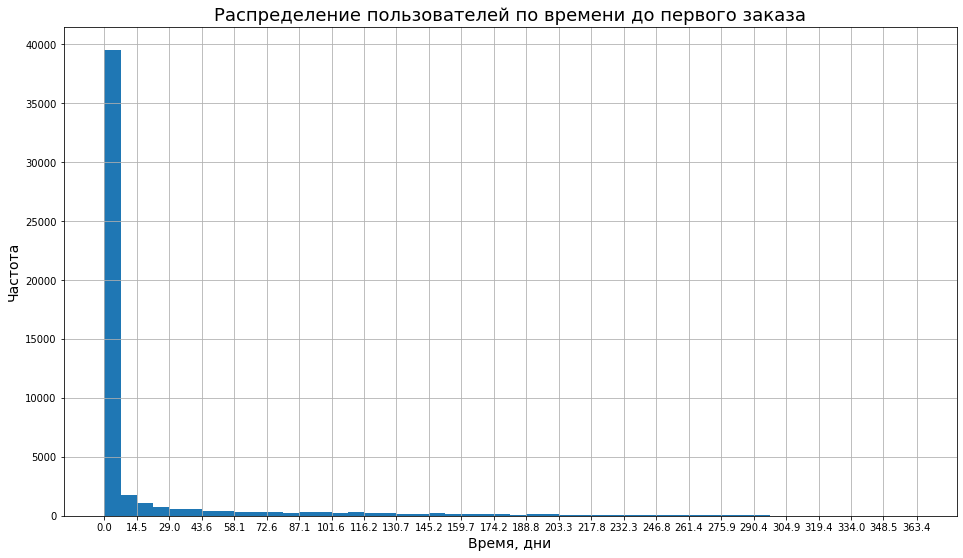

In [58]:
hist_bins = 25
hist_range = orders['time_until_buy'].dt.days
ticks = pd.cut(hist_range, bins=hist_bins, labels=False, retbins=True, right=False)[1]

hist_range.plot(kind='hist', bins=50, grid=True, figsize=(16,9))
plt.xticks(ticks)
plt.title('Распределение пользователей по времени до первого заказа', fontsize=18)
plt.xlabel('Время, дни', fontsize=14)
plt.ylabel('Частота', fontsize=14)

Большая часть пользователей совершает первый заказ в течении недели после первого входа на платформу

### Количество покупок на пользователя<a id="stage_3_orders_orders_num"></a>

Создадим сводную таблицу в разрезе пользователей и выведем сведения о ней методом describe

In [59]:
orders.pivot_table(index='uid', values='buy_ts', aggfunc='count').describe().round(2)

,buy_ts
count,36522.00
mean,1.38
std,3.45
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,239.00


В среднем на одного пользователя приходится 1.38 заказов через платформу, медианное количество заказов 1, а максимальное количество составляет 239 заказов на одного пользователя

Рассчитаем процент пользователей которые совершали заказы на плафторме

In [60]:
print('Посещений:', visits['uid'].count())
print('Заказов:', orders['uid'].count())
print('Отношение: {:.2%}'.format((orders['uid'].count() / visits['uid'].count()), ))

Посещений: 359398
Заказов: 50414
Отношение: 14.03%


### Life Time Value<a id="stage_3_orders_LTV"></a>

LTV мы будем считать по когортам, объединяющий признак - первый месяц покупки, для его расчета добавим в таблицу столбец с месяцем первого заказа

In [61]:
orders['first_buy_month'] = orders['first_buy'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,buy_month,first_buy,first_activity,time_until_buy,first_buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01 00:09:00,00:01:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:14:00,00:11:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01 00:25:00,00:02:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01 00:14:00,00:15:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01 07:31:00,00:27:00,2017-06-01


Создадим когорты с выручкой по месяцам

In [62]:
cohorts_orders = orders.pivot_table(index=['first_buy_month','buy_month'], values='revenue', aggfunc='sum').reset_index()
cohorts_orders.head()

,first_buy_month,buy_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Для каждой когорты определим месяц жизни на котором были совершены покупки

In [63]:
cohorts_orders['lifetime'] = (cohorts_orders['buy_month'] - cohorts_orders['first_buy_month']) / np.timedelta64(1,'M')
cohorts_orders['lifetime'] = cohorts_orders['lifetime'].round().astype('int')
cohorts_orders.head()

,first_buy_month,buy_month,revenue,lifetime
0,2017-06-01,2017-06-01,9557.49,0
1,2017-06-01,2017-07-01,981.82,1
2,2017-06-01,2017-08-01,885.34,2
3,2017-06-01,2017-09-01,1931.30,3
4,2017-06-01,2017-10-01,2068.58,4


Расчитаем количество пользователей в каждой когорте

In [64]:
cohorts_users = orders.pivot_table(index='first_buy_month', values='uid', 
                                   aggfunc=lambda x: len(x.unique())).reset_index()
cohorts_users.columns = ['first_buy_month','un_users_cnt']
cohorts_users.head()

,first_buy_month,un_users_cnt
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Добавим их к таблице с выручкой по когортам

In [65]:
cohorts_orders = cohorts_orders.merge(cohorts_users, on='first_buy_month', how='left')
cohorts_orders.head()

,first_buy_month,buy_month,revenue,lifetime,un_users_cnt
0,2017-06-01,2017-06-01,9557.49,0,2023
1,2017-06-01,2017-07-01,981.82,1,2023
2,2017-06-01,2017-08-01,885.34,2,2023
3,2017-06-01,2017-09-01,1931.30,3,2023
4,2017-06-01,2017-10-01,2068.58,4,2023


Так как сведений о маржинальности в нашем распоряжении нет то LTV мы будем считать по имеющимся сведениям о выручке, для этого разделим выручку за каждый месяц на количество пользователей в когорте

In [66]:
cohorts_orders['ltv'] = round(cohorts_orders['revenue'] / cohorts_orders['un_users_cnt'], 2)
cohorts_orders.head()

,first_buy_month,buy_month,revenue,lifetime,un_users_cnt,ltv
0,2017-06-01,2017-06-01,9557.49,0,2023,4.72
1,2017-06-01,2017-07-01,981.82,1,2023,0.49
2,2017-06-01,2017-08-01,885.34,2,2023,0.44
3,2017-06-01,2017-09-01,1931.30,3,2023,0.95
4,2017-06-01,2017-10-01,2068.58,4,2023,1.02


Создадим сводную таблицу для вывода карты теплоты

In [67]:
ltv_pivot = cohorts_orders.pivot_table(index = 'first_buy_month', columns='lifetime', values='ltv')

Text(123.0, 0.5, 'Когорта')

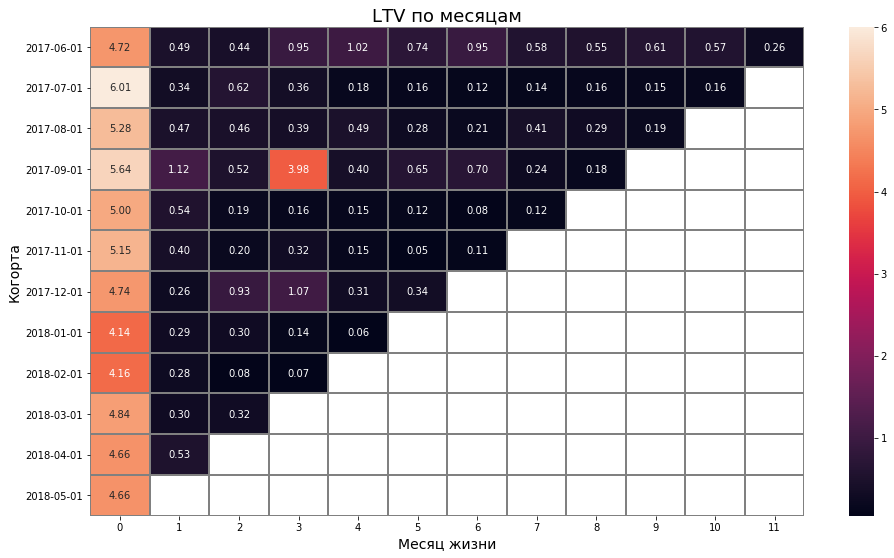

In [68]:
plt.figure(figsize=(16,9))
sns.heatmap(ltv_pivot, annot=True, linewidths=1, linecolor='gray', 
            yticklabels=ltv_pivot.index.date, fmt='.2f')
plt.title('LTV по месяцам', fontsize=18)
plt.xlabel('Месяц жизни', fontsize=14)
plt.ylabel('Когорта', fontsize=14)

Основную долю выручки когорты приносят в первый месяц жизни, в сочетании с низним рейтингом удержания это свидетельствует о том что в основном сервисом посетители пользуются один раз, при первом посещении. Однако резко выделяется LTV сентябрьской когорты за декабрь

Рассчитаем LTV по когортам за все время

In [69]:
cohorts_orders.pivot_table(index = 'first_buy_month', values='ltv', aggfunc='sum').round(2)

,ltv
first_buy_month,
2017-06-01,11.88
2017-07-01,8.40
2017-08-01,8.47
2017-09-01,13.43
2017-10-01,6.36
2017-11-01,6.38
2017-12-01,7.65
2018-01-01,4.93
2018-02-01,4.59


Стоит отметить метрику LTV сентябрьской когорты - она моложе самой первой когорты на 3 месяца а выручки за все время средний пользователь из нее принес больше

В среднем по каждой когорте выручка с каждого пользователя за все время

In [70]:
cohorts_orders.pivot_table(index = 'first_buy_month', values='ltv', aggfunc='sum')['ltv'].mean().round(2)

7.28

### Выручка по источникам привлечения<a id="stage_3_orders_per_source"></a>

Для того чтобы рассчитать выручку в разрезе источников привлечения нам необходимо в таблице orders отметить источник привлечения, сначала определим из какого источника пришел каждый пользователь, для этого отсортируем таблицу visits по возрастанию даты посещения и выделим для каждого uid первый встречающийся источник привлечения

In [71]:
first_visit_source = visits.sort_values(['uid', 'start_ts']).pivot_table(index='uid', values='source_id', aggfunc='first')
first_visit_source = first_visit_source.reset_index()
first_visit_source.columns = ['uid','first_source_id']
first_visit_source.head()

,uid,first_source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


Добавим источник привлечения к таблице с заказами

In [72]:
orders = orders.merge(first_visit_source, on='uid', how='left')
orders.head()

,buy_ts,revenue,uid,buy_month,first_buy,first_activity,time_until_buy,first_buy_month,first_source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01 00:09:00,00:01:00,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:14:00,00:11:00,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01 00:25:00,00:02:00,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01 00:14:00,00:15:00,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01 07:31:00,00:27:00,2017-06-01,3


Создадим сводную таблицу, в которой рассчитаем суммарную выручку и количество покупателей в разрезе источников привлечения

In [73]:
revenue_per_source = orders.pivot_table(index='first_source_id', values=['revenue','uid'], 
                                        aggfunc={'revenue':'sum','uid':'count'}).reset_index()
revenue_per_source.columns = ['first_source_id','revenue','buyer_count']
revenue_per_source

,first_source_id,revenue,buyer_count
0,1,31090.55,5223
1,2,46923.61,6392
2,3,54511.24,13289
3,4,56693.41,12894
4,5,52624.02,9406
5,7,1.22,1
6,9,5759.40,1647
7,10,4450.33,1562


Выведем на экран продажи по источнику привлечения 7

In [74]:
orders.query('first_source_id == 7')

,buy_ts,revenue,uid,buy_month,first_buy,first_activity,time_until_buy,first_buy_month,first_source_id
5485,2017-08-17 11:20:00,1.22,11377414203346034748,2017-08-01,2017-08-17 11:20:00,2017-08-17 10:28:00,00:52:00,2017-08-01,7


Одна покупка которая принесла 1.22 выручки, удалим ее из таблицы в связи с тем что этот источник будет отображаться на графике пустым столбцом

In [75]:
orders = orders.drop(orders.query('first_source_id == 7').index).reset_index(drop=True)

Text(0.5, 0, 'Источник привлечения')

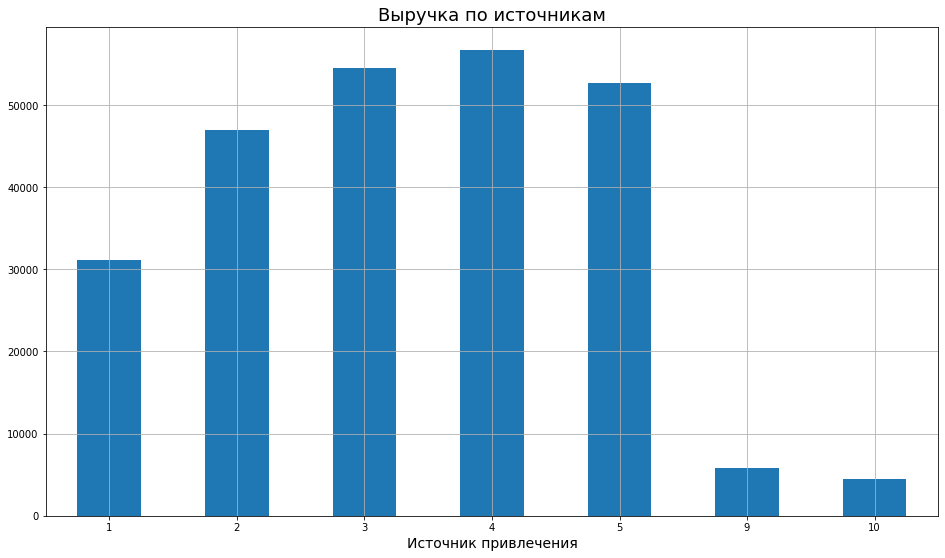

In [76]:
orders.pivot_table(index=['first_source_id'], values=['revenue','uid'], 
                   aggfunc={'revenue':'sum','uid':'count'}).reset_index().\
       plot(kind='bar', x='first_source_id', y='revenue', figsize=(16,9), legend=False, grid=True, rot=0)
plt.title('Выручка по источникам', fontsize=18)
plt.xlabel('Источник привлечения', fontsize=14)

Наибольшее количество выручки принесли пользователи привлеченные источниками 3, 4 и 5 - более 50 тысяч на каждый

## Затраты на привлечение<a id="stage_3_costs"></a>

Всего на привлечение пользователей было потрачено

In [77]:
costs['costs'].sum()

329131.62

### Стоимость привлечения пользователей в разрезе источников<a id="stage_3_costs_per_source"></a>

На основании сводной таблицы содержащей пользователей и источник из которого они пришли рассчитаем сколько посетителей принес каждый источник

In [78]:
users_per_source = visits.sort_values(['uid', 'start_ts']).pivot_table(index='uid', values=['source_id','day'], 
                                                                       aggfunc='first').reset_index()
users_per_source = users_per_source.pivot_table(index=['day','source_id'], values='uid', aggfunc='count').reset_index()
users_per_source.columns = ['dt','source_id','user_count']
users_per_source.head()

,dt,source_id,user_count
0,2017-06-01,1,47
1,2017-06-01,2,70
2,2017-06-01,3,180
3,2017-06-01,4,137
4,2017-06-01,5,111


Добавим эту информацию в таблицу содержащую записи о затратах на маркетинг по дням

In [79]:
costs = costs.merge(users_per_source, on=['dt','source_id'], how='left')
costs.head()

,source_id,dt,costs,user_count
0,1,2017-06-01,75.20,47.0
1,1,2017-06-02,62.25,27.0
2,1,2017-06-03,36.53,22.0
3,1,2017-06-04,55.00,23.0
4,1,2017-06-05,57.08,39.0


Создадим сводную таблицу затрат на каждый источник и количества привлеченных пользователей за все время наблюдения

In [80]:
costs_pivot = costs.pivot_table(index='source_id', values=['costs','user_count'], 
                                aggfunc={'costs':'sum','user_count':'sum'}).round(2).reset_index()
costs_pivot['costs, %'] = round(costs_pivot['costs'] / costs_pivot['costs'].sum() * 100, 2)
costs_pivot['user_count, %'] = round(costs_pivot['user_count'] / costs_pivot['user_count'].sum() * 100, 2)
costs_pivot

,source_id,costs,user_count,"costs, %","user_count, %"
0,1,20833.27,9468.0,6.33,4.15
1,2,42806.04,17616.0,13.01,7.72
2,3,141321.63,66116.0,42.94,28.98
3,4,61073.60,72346.0,18.56,31.71
4,5,51757.10,49237.0,15.73,21.58
5,9,5517.49,6448.0,1.68,2.83
6,10,5822.49,6903.0,1.77,3.03


Отобразим диаграмму распределения долей маркетинговых затрат на источник, пользователей привлеченных через этот источник

Text(0, 0.5, '%')

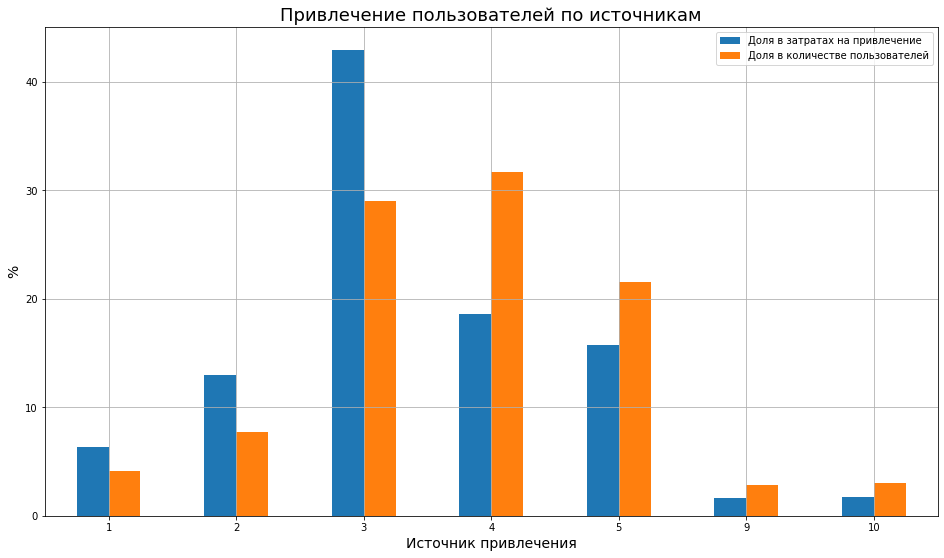

In [81]:
costs_pivot.plot(kind='bar', x='source_id', y=['costs, %','user_count, %'], figsize=(16,9), legend=False, grid=True, rot=0)
plt.legend(['Доля в затратах на привлечение','Доля в количестве пользователей'])
plt.title('Привлечение пользователей по источникам', fontsize=18)
plt.xlabel('Источник привлечения', fontsize=14)
plt.ylabel('%', fontsize=14)

Самым не эффективным источником привлечения является источник 3 - стоимость привлечения пользователей через этот источник составили 43% всех маркетинговых затрат, и привлекли 29% пользователей, в то время как затраты на источник 4 составили только 18.6% а привлекли 31% пользователей - самая большая доля привлеченных пользователей среди всех источников

### Затраты на привлечение пользователей по месяцам<a id="stage_3_costs_monthly"></a>

Для расчета ежемесячных затрат добавим в таблицу столбец в котором сохраним месяц привлечения

In [82]:
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs.head()

,source_id,dt,costs,user_count,dt_month
0,1,2017-06-01,75.20,47.0,2017-06-01
1,1,2017-06-02,62.25,27.0,2017-06-01
2,1,2017-06-03,36.53,22.0,2017-06-01
3,1,2017-06-04,55.00,23.0,2017-06-01
4,1,2017-06-05,57.08,39.0,2017-06-01


Создадим сводную таблицу затрат по месяцам

In [83]:
cost_per_month = costs.pivot_table(index='dt_month', values='costs', aggfunc='sum').reset_index()
cost_per_month.columns = ['first_buy_month','costs']
cost_per_month

,first_buy_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


Отобразим ее на диаграмме

Для корректного отображения отметок по оси x добавим временную колонку с датой в которую запишем только дату, без времени

In [84]:
cost_per_month['first_buy_month_dates'] = cost_per_month['first_buy_month'].dt.date

Text(0, 0.5, 'Затрты')

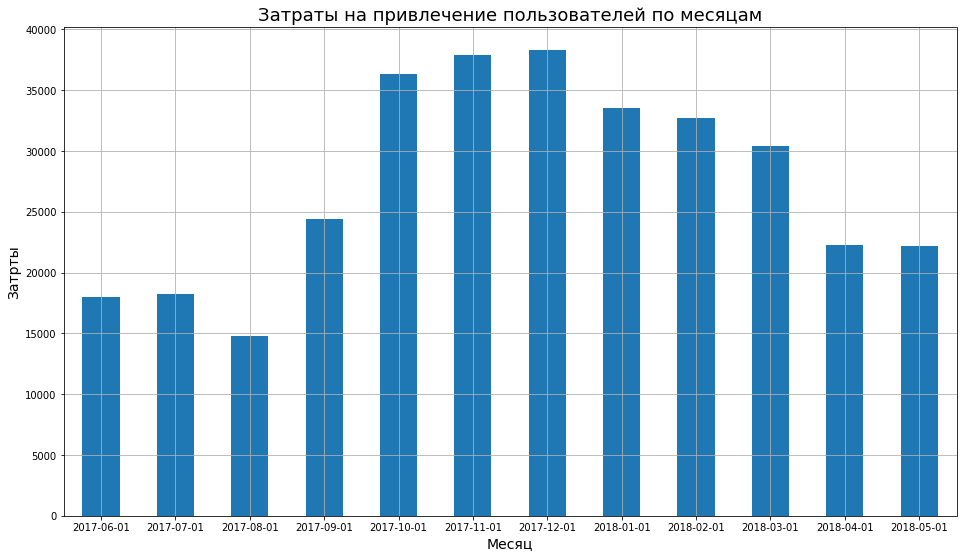

In [85]:
cost_per_month.plot(kind='bar', x='first_buy_month_dates', y='costs', figsize=(16,9), legend=False, grid=True, rot=0)
plt.title('Затраты на привлечение пользователей по месяцам', fontsize=18)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Затрты', fontsize=14)

В конце года затраты на привлечение увеличиваются, что, как мы ранее выяснили, приводит к значительному увеличению количества пользователей которые пользуются сервисом

Удалим временный столбец

In [86]:
cost_per_month = cost_per_month.drop('first_buy_month_dates', axis=1)

### Стоимость привлечения одного пользователя<a id="stage_3_costs_per_user"></a>

Для рассчета метрик CAC и ROI в разрезе источников привлечения из таблицы orders выделим количество покупателей пришедших из каждого источника

In [87]:
byers_per_source = orders.pivot_table(index=['first_source_id','first_buy_month'], values=['uid','revenue'], 
                                      aggfunc={'uid':'count','revenue':'sum'}).reset_index()
byers_per_source.columns = ['source_id','month','revenue','users']
byers_per_source.head()

,source_id,month,revenue,users
0,1,2017-06-01,6392.39,1143
1,1,2017-07-01,3342.52,410
2,1,2017-08-01,2110.91,238
3,1,2017-09-01,2364.55,363
4,1,2017-10-01,2850.08,504


На основании таблицы costs создадим сводную таблицу затрат на каждый источник привлечения в разрезе месяцев

In [88]:
costs_per_source = costs.pivot_table(index=['source_id','dt_month'], values='costs', aggfunc='sum').reset_index()
costs_per_source.columns = ['source_id','month','costs']
costs_per_source.head()

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75


Посчитаем CAC для каждого источника за каждый месяц

In [89]:
cohorts_per_source = costs_per_source.merge(byers_per_source, on=['source_id','month'], how='left')
cohorts_per_source['cac'] = cohorts_per_source['costs'] / cohorts_per_source['users']
cohorts_per_source.head()

,source_id,month,costs,revenue,users,cac
0,1,2017-06-01,1125.61,6392.39,1143,0.984786
1,1,2017-07-01,1072.88,3342.52,410,2.616780
2,1,2017-08-01,951.81,2110.91,238,3.999202
3,1,2017-09-01,1502.01,2364.55,363,4.137769
4,1,2017-10-01,2315.75,2850.08,504,4.594742


Посчитаем метрику CAC по каждому источнику за год

In [90]:
data = []
for source in cohorts_per_source['source_id'].unique():
    cac = cohorts_per_source.query('source_id == @source')['cac'].mean().round(2)
    data.append([source,cac])
cac_per_source = pd.DataFrame(data, columns=['source','cac'])
cac_per_source

,source,cac
0,1,4.60
1,2,7.07
2,3,10.85
3,4,5.06
4,5,5.63
5,9,3.78
6,10,4.15


Отобразим ее на графике

Text(0, 0.5, 'Затрты')

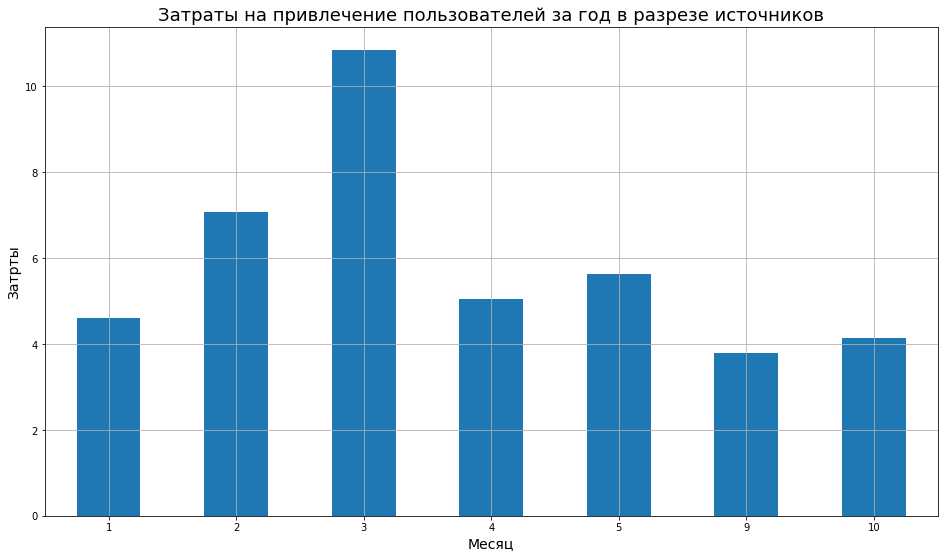

In [91]:
cac_per_source.plot(kind='bar', x='source', y='cac', figsize=(16,9), legend=False, grid=True, rot=0)
plt.title('Затраты на привлечение пользователей за год в разрезе источников', fontsize=18)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Затрты', fontsize=14)

Дороже всего обходится привлечение пользователя по третьему источнику - 10.85

Для расчета показателя CAC в целом за год по всем иточникам в таблицу с когортами по заказам в месяц добавим стоимость привлечения пользователей по месяцам

In [92]:
cohorts_orders = cohorts_orders.merge(cost_per_month, on='first_buy_month', how='left')
cohorts_orders.head()

,first_buy_month,buy_month,revenue,lifetime,un_users_cnt,ltv,costs
0,2017-06-01,2017-06-01,9557.49,0,2023,4.72,18015.0
1,2017-06-01,2017-07-01,981.82,1,2023,0.49,18015.0
2,2017-06-01,2017-08-01,885.34,2,2023,0.44,18015.0
3,2017-06-01,2017-09-01,1931.30,3,2023,0.95,18015.0
4,2017-06-01,2017-10-01,2068.58,4,2023,1.02,18015.0


Рассчитаем показатели CAC (затраты на привлечение одного пользователя)

In [93]:
cohorts_orders['cac'] = cohorts_orders['costs'] / cohorts_orders['un_users_cnt']
cohorts_orders.head()

,first_buy_month,buy_month,revenue,lifetime,un_users_cnt,ltv,costs,cac
0,2017-06-01,2017-06-01,9557.49,0,2023,4.72,18015.0,8.905091
1,2017-06-01,2017-07-01,981.82,1,2023,0.49,18015.0,8.905091
2,2017-06-01,2017-08-01,885.34,2,2023,0.44,18015.0,8.905091
3,2017-06-01,2017-09-01,1931.30,3,2023,0.95,18015.0,8.905091
4,2017-06-01,2017-10-01,2068.58,4,2023,1.02,18015.0,8.905091


Выведем средний показатель CAC за год

In [94]:
cohorts_orders['cac'].mean().round(2)

9.32

### Return On Investment<a id="stage_3_costs_ROI"></a>

Для расчета метрики ROI (окупаемость инвестиций) разделим ранее рассчитаный LTV на CAC

In [95]:
cohorts_orders['roi'] = cohorts_orders['ltv'] / cohorts_orders['cac']
cohorts_orders.head()

,first_buy_month,buy_month,revenue,lifetime,un_users_cnt,ltv,costs,cac,roi
0,2017-06-01,2017-06-01,9557.49,0,2023,4.72,18015.0,8.905091,0.530034
1,2017-06-01,2017-07-01,981.82,1,2023,0.49,18015.0,8.905091,0.055025
2,2017-06-01,2017-08-01,885.34,2,2023,0.44,18015.0,8.905091,0.049410
3,2017-06-01,2017-09-01,1931.30,3,2023,0.95,18015.0,8.905091,0.106681
4,2017-06-01,2017-10-01,2068.58,4,2023,1.02,18015.0,8.905091,0.114541


Создадим сводную таблицу и построим карту теплоты

In [96]:
roi_pivot = cohorts_orders.pivot_table(index='first_buy_month', columns='lifetime', values='roi', aggfunc='mean')
roi_pivot = roi_pivot.cumsum(axis=1).round(2)

Text(123.0, 0.5, 'Когорта')

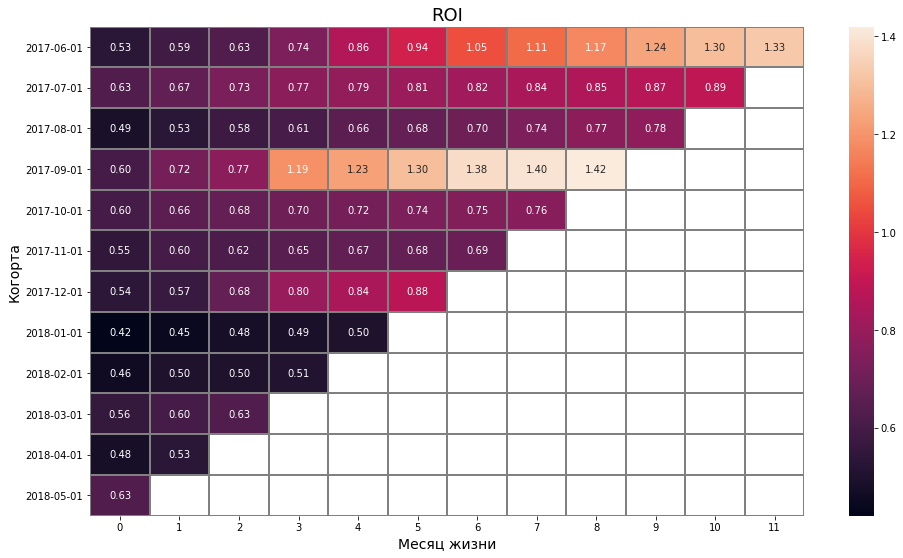

In [97]:
plt.figure(figsize=(16,9))
sns.heatmap(roi_pivot, annot=True, linewidths=1, linecolor='gray', 
            yticklabels=roi_pivot.index.date, fmt='.2f')
plt.title('ROI', fontsize=18)
plt.xlabel('Месяц жизни', fontsize=14)
plt.ylabel('Когорта', fontsize=14)

За год успели окупить инвестиции в привлечение пользователи двух когорт - июньской и сентябрьской, близки к окупаемости пользователи когорт время жизни которых включило конец года

Рассчитаем среднее время окупаемости когорт

In [98]:
cohorts_orders.pivot_table(index='first_buy_month', columns='lifetime', 
                           values='roi', aggfunc='mean').cumsum(axis=1).mean(axis=0).round(2)

lifetime
0     0.54
1     0.58
2     0.63
3     0.72
4     0.78
5     0.86
6     0.90
7     0.97
8     1.05
9     0.96
10    1.10
11    1.33
dtype: float64

Когорты окупаются на девятый месяц жизни

Рассчитаем окупаемость инвестиций по каждому источнику привлечения

In [99]:
orders_per_source = orders.pivot_table(index=['first_source_id','first_buy_month','buy_month'], values=['uid','revenue'], 
                                    aggfunc={'uid':'count','revenue':'sum'}).reset_index()
orders_per_source['lifetime'] = (orders_per_source['buy_month'] - orders_per_source['first_buy_month']) / np.timedelta64(1,'M')
orders_per_source['lifetime'] = orders_per_source['lifetime'].round().astype('int')
orders_per_source.head()

,first_source_id,first_buy_month,buy_month,revenue,uid,lifetime
0,1,2017-06-01,2017-06-01,1378.70,268,0
1,1,2017-06-01,2017-07-01,414.98,80,1
2,1,2017-06-01,2017-08-01,419.43,87,2
3,1,2017-06-01,2017-09-01,714.24,119,3
4,1,2017-06-01,2017-10-01,811.20,114,4


Перед объединением переименуем столбцы

In [100]:
costs_per_source.columns=['first_source_id','first_buy_month','costs']

Объеденим две таблицы (заказы по источникам и стоимости по источникам) в одну и рассчитаем LTV, CAC и ROI по каждому источнику

In [101]:
cohorts_per_source = orders_per_source.merge(costs_per_source, on=['first_source_id','first_buy_month'], how='left')

cohorts_per_source['ltv'] = cohorts_per_source['revenue'] / cohorts_per_source['uid']
cohorts_per_source['cac'] = cohorts_per_source['costs'] / cohorts_per_source['uid']
cohorts_per_source['roi'] = cohorts_per_source['ltv'] / cohorts_per_source['cac']
cohorts_per_source.head()

,first_source_id,first_buy_month,buy_month,revenue,uid,lifetime,costs,ltv,cac,roi
0,1,2017-06-01,2017-06-01,1378.70,268,0,1125.61,5.144403,4.200037,1.224847
1,1,2017-06-01,2017-07-01,414.98,80,1,1125.61,5.187250,14.070125,0.368671
2,1,2017-06-01,2017-08-01,419.43,87,2,1125.61,4.821034,12.938046,0.372625
3,1,2017-06-01,2017-09-01,714.24,119,3,1125.61,6.002017,9.458908,0.634536
4,1,2017-06-01,2017-10-01,811.20,114,4,1125.61,7.115789,9.873772,0.720676


Соберем сведения об окупаемости источников в одну таблицу и выведем ее на экран

In [116]:
roi = pd.DataFrame(range(0,12), columns=['lifetime'])

for source in cohorts_per_source['first_source_id'].unique():
    roi_pivot = cohorts_per_source.query('first_source_id == @source').pivot_table(index='first_buy_month', 
                                               columns='lifetime', values='roi', aggfunc='mean').cumsum(axis=1).mean(axis=0).round(2)
    roi_pivot.name = source
    roi = roi.merge(roi_pivot, on='lifetime', how='left')

roi = roi.drop('lifetime', axis=1)
roi

,1,2,3,4,5,9,10
0,0.89,0.55,0.34,0.76,0.66,0.77,0.73
1,1.05,0.63,0.36,0.78,0.72,0.85,0.71
2,1.26,0.78,0.37,0.79,0.78,0.94,0.77
3,1.36,0.94,0.38,0.81,1.11,1.04,0.69
4,1.57,1.09,0.39,0.84,1.23,1.09,0.74
5,1.77,1.23,0.41,0.90,1.39,1.22,0.75
6,2.04,1.03,0.42,0.98,1.55,1.33,0.88
7,2.36,1.14,0.44,0.90,1.78,1.46,0.77
8,2.86,1.22,0.45,0.90,2.02,1.56,0.61
9,3.46,0.99,0.43,0.95,1.42,1.43,0.90


Анализ окупаемости в разрезе источников показал что в течении года окупились источники 1, 2, 4, 5 и 9. Затраты на привлечение пользователей по источникам 3 и 10 не окупились, но десятый источник очень близок к окупаемости, в отличии от третьего, который не окупил даже половины затрат

## Вывод<a id="stage_3_summary"></a>

**Посещаемость**

Всего, за год на обеих платформах было 359398 посещений, из них уникальных пользователей 235868. Что касается уникальных посещения по периодам то в день, в среднем, на каждого пользователя приходилось 1.1 сессий, в неделю и в месяц этот показатель несколько больше - 1.2 и 1.3 

В разрезе платформ посещаемость распределена следующим образом:

| платформа | в день | в месяц | в неделю |
| --- | --- | --- | --- |
| desktop | 659.24 | 4129.51 | 16724.92 |
| touch | 252.87 | 1634.92 | 6825.92 |
    
Количество посетителей которые заходят на Афишу с настолького компьютера на 40% больше чем посетителей с мобильных устройств, в конце года количество пользователей значительно увеличивается, это может свидетельствовать о сезонности спроса

Если мы рассмотрим количество сессий на одного пользователя по месяцам, за весь год, то мы увидим что оно незначительно увеличивается в конце года (с 1.2 до 1.3), однако его увеличение не достаточно для того чтобы объяснить значительный рост общего количества посещений в декабре и январе (42 и 43 тысячи), это значит что в конце года мы получаем больше уникальных посетителей, еще одно подтверждение сезонности спроса

Средняя длительность сессии 643 секунды, медианная 300 секунд, причем пользователи использующие мобильные платформы проводят на сайте примерно на треть меньше времени чем пользователи которые зашли с настолького компьтера

В течении года коэффициент удержания снижается, но наблюдается рост количества возвращающихся пользователей во время новогодних праздников (декабрь-январь). В среднем коэффициент удержания среди пользователей которые используют настольные компьютеры выше чем на мобильных платформах

**Заказы**

За год выручка от комиссий за покупки пользователей составила 252057.2

Среди всех посетителей 14% совершили 50415 покупок, средний чек составил 5 а медианный 2.5, распределение по перцентилям показывает что 75% покупок уложились в средний чек, всего по месяцам выручка составила 19389.02, в конце года она значительно возрастает (36388.60 в декабре)

Анализ времени прошедшего между первым посещением и первой покупкой показал что средний период ожидания 17 дней, а медианный 22 минуты, подавляющее количество пользователей совершило первый заказ в течении недели после первого входа на платформу

В среднем на одного пользователя приходится 1.38 заказов через платформу (что сопоставимо со средним количеством сессий в месяц), медианное количество заказов 1, а максимальное количество составляет 239 заказов на одного пользователя

Когортный анализ выручки показал что основную долю выручки когорты приносят в первый месяц жизни, в сочетании с низним рейтингом удержания это свидетельствует о том что в большая часть посетителей совершает покупки один раз, при первом посещении

В среднем по когортам выручка на пользователя в рассматриваемом периоде составила 7.28

Наибольшее количество выручки принесли пользователи привлеченные источниками 3, 4 и 5 - более 50 тысяч на каждый источник

**Затраты на привлечение**

Всего на привлечение пользователей было потрачено 329131.62, средняя стоимость привлечения одного пользователя составила 9.32, дороже всего обходится привлечение по источникам 1, 2 и 3 - более 2 за одного пользователя, привлечение пользователей по источникам 4, 5, 9 и 10 обходится в два раза дешевле

Самым не эффективным источником привлечения является источник 3 - стоимость привлечения пользователей через этот источник составила 43% всех маркетинговых затрат, и привлекла 29% пользователей, в то время как затраты на источник 4 составили только 18.6% а привлекли 31% пользователей - самая большая доля привлеченных пользователей среди всех источников

В конце года затраты на маркетинг увеличиваются, что, как мы ранее выяснили, приводит к значительному увеличению количества пользователей которые пользуются сервисом

За год успели окупить инвестиции в привлечение пользователи двух когорт - июньской и сентябрьской, близки к окупаемости пользователи когорт время жизни которых включило конец года, в среднем когорты окупаются на девятый месяц жизни

Анализ окупаемости в разрезе источников показал что в течении года окупились источники 1, 2, 4, 5 и 9. Затраты на привлечение пользователей по источникам 3 и 10 не окупились, но десятый источник очень близок к окупаемости, в отличии от третьего, который не окупил даже половины затрат

# Этап 4 - Рекомендации<a id="stage_4"></a>

На предыдущем этапе мы рассчитали затраты на привлечение одного пользователя и количество выручки которую он принесет нам за время своей жизни: привлечение одного пользователя стоит 9.32, за рассматриваемый период он принес 7.28 выручки

Всего, за год, на маркетинг было затрачено 329131.62, а выручка с заказов пользователей составила 252057.2

Если судить только по этим показателям - сервис приносит 77074.42 убытков в год

Объединим стоимость привлечения по каждому источнику, количество привлеченных пользователей и выручку

In [103]:
report = costs_pivot.merge(cac_per_source, left_on='source_id', 
                      right_on='source', how='left')
report.index = report['source_id']
report = report.drop(['source','source_id'], axis=1)
report = report[['costs','costs, %','user_count','user_count, %','cac']]
report.style.background_gradient(cmap='Reds')

,costs,"costs, %",user_count,"user_count, %",cac
source_id,,,,,
1,20833.3,6.33,9468,4.15,4.6
2,42806,13.01,17616,7.72,7.07
3,141322,42.94,66116,28.98,10.85
4,61073.6,18.56,72346,31.71,5.06
5,51757.1,15.73,49237,21.58,5.63
9,5517.49,1.68,6448,2.83,3.78
10,5822.49,1.77,6903,3.03,4.15


Количество  пользователей привлеченных через первый и второй источники не велико, но и затраты соответствующие 6.33% и 13%, из двух этих источников можно рекомендовать снизить затраты второй, так как стоимость привлечения новых пользователей через него получается необснованно высокой, затраты на первый источник можно оставить на прежнем уровне

Затраты на привлечение по третьему источнику выглядят самымы не эффективными, стоимость привлечения одного пользователя самая высокая, всего на источник затрачено 43% всех маркетинговых затрат а пользователей привлечено только 29%, затраты на третий источник нужно значительно снизить

Четвертый источник привлечения можно признать самым эффективным, затраты составили 18.6% а привлечено было 31.7% пользователей, что делает стоимость привлечения одного пользователя самой низкой из всех источников, затраты на этот источник стоит оставить без изменений

Количество пользователей привлеченных через пятый источник меньше на 10% чем через четвертый, а затраты ниже только на 2.8%, то есть резульаты хуже, но сравнимы, затраты стоит оставить без изменений

Девятый и десятый источники используются недостаточно, затраты составляют менее 2% на каждый а привлечено 2.83% и 3% пользователей, средства, освобожденные после снижения затрат на  первый, второй и третий источники стоит направить именно сюда, так как, судя по стоимости привлечения одного пользователя, при соответствующем финансировании, эти источники дадут результаты сравнимые с четвертым источником

Кроме изменения структуры маркетинговых затрат необходимо увеличить показатель удержания пользователей, в этом могут помочь различные программы лояльности

Дополнительно стоит обратить внимание на привлечение пользователей мобильных устройств так как потенциал роста на этой платформе еще не выбран (пользователей на 40% меньше чем на настольных компьютерах)

# Общий вывод<a id="conclusion"></a>

После загрузки данных мы обнаружили что перед началом анализа необходимо провести предобработку данных: изменить тип данных в столбцах содержащих отметки о времени и изменить наименования столбцов

В процессе предобработки мы удалили две записи в которых время начала сессии было позже ее начала из таблицы visits

Далее мы провели анализ данных и при выявили следующее:

**Посещаемость**

Всего, за год на обеих платформах было 359398 посещений, из них уникальных пользователей 235868. Количество посетителей которые заходят на Афишу с настолького компьютера на 40% больше чем посетителей с мобильных устройств. На каждого пользователя приходилось 1.1 сессий, однако в неделю и в месяц этот показатель несколько больше - 1.2 и 1.3. Средняя длительность сессии составила 643 секунды, на моибльных устройствах сессии длились на треть меньше

В течении года коэффициент удержания снижается, но наблюдается рост количества возвращающихся пользователей во время новогодних праздников (декабрь-январь). В среднем коэффициент удержания среди пользователей которые используют настольные компьютеры выше чем на мобильных платформах

**Заказы**

За год выручка от комиссий за покупки пользователей составила 252057.2, В среднем на одного пользователя приходится 1.38 заказов через платформу (что сопоставимо со средним количеством сессий в месяц)

Когортный анализ выручки показал что основную долю выручки когорты приносят в первый месяц жизни, в сочетании с низним рейтингом удержания это свидетельствует о том что в подавляющая часть посетителей совершает покупки один раз, при первом посещении, однако показатели среднего количества сессий и количества заказов пользователей показывает что некоторая часть пользователей продолжает возвращаться в течении года

В среднем по когортам выручка на пользователя, в рассматриваемом периоде, составила 7.28

**Затраты на привлечение**

Всего на привлечение пользователей было потрачено 329131.62, анализ источников привлечения пользователей выявил что больше всего было затрачено на третий источник (43% всех затрат) с которого пришло 28% пользователей, больше всего пользователей было привлечено четвертым источником - 31%, а затраты на его использование составили 18.5% от всех маркетинговых затрат

За год успели окупить инвестиции в привлечение пользователи двух когорт - июньской и сентябрьской, близки к окупаемости пользователи когорт время жизни которых включило конец года, в среднем когорты окупаются на 9 месяц жизни

Стоимость привлечения одного пользователя, в среднем по когортам, составила 9.32

**Рекомендации**

Нами выдвинуты следующие рекомендации для маркетологов

* Снизить затраты на 2 и 3 источники привлечения

* Увеличить затраты на 9 и 10 источники

* Увеличить коэффициент удержания пользователей путем разработки программ лояльности

* Дополнительно стоит обратить внимание на привлечение пользователей мобильных устройств так как потенциал роста на этой платформе еще не выбран (пользователей на 40% меньше чем на настольных компьютерах)